In [7]:
# The "root" folder that holds all the experiment data; must follow a strict folder structure.
ROOT = "data"

# The experiment type folder to look into, if each experiment has a "hand" and a "controller" folder.
FOLDER = "hand"

# Number of participants and experiments to index; TODO: Detect this automatically.
PARTICIPANTS = 4
EXPERIMENTS = 10

# The list of files to analyze.
FILE_LIST = [
        'Ball_1.csv', 'Ball2_1.csv', 'Ball3_1.csv', 'Ball4_1.csv', 'Ball5_1.csv',
        'Ball6_1.csv', 'Ball7_1.csv', 'Ball8_1.csv', 'Ball9_1.csv', 'Ball10_1.csv',
        'CubeMetal_1.csv', 'CubeNormal_1.csv', 'CubeWood_1.csv',
        'Cup_1.csv', 'Cup2_1.csv', 'Hammer_1.csv', 'Mallet_1.csv'
    ]

# The test size for the test/training data ratio. Standard is 80% training data, 20% test data.
TEST_SIZE = 0.5

# Various features arrays categorized by the data they hold. 
imu_cols = ["imu_pos_x", "imu_pos_y", "imu_pos_z", "imu_rot_x", "imu_rot_y", "imu_rot_z"]
object_cols = ['lv_x', 'lv_y', 'lv_z', 'av_x', 'av_y', 'av_z', 'pos_x', 'pos_y', 'pos_z']
hands_cols = [
    # 'lh_pos_x', 'lh_pos_y', 'lh_pos_z', 'lh_rot_x', 'lh_rot_y', 'lh_rot_z',
    'rh_pos_x', 'rh_pos_y', 'rh_pos_z', 'rh_rot_x', 'rh_rot_y', 'rh_rot_z'
]
fingers_cols = [
    # 'lh_thumb_x', 'lh_thumb_y', 'lh_thumb_z',
    # 'lh_index_x', 'lh_index_y', 'lh_index_z',
    # 'lh_middle_x', 'lh_middle_y', 'lh_middle_z',
    # 'lh_ring_x', 'lh_ring_y', 'lh_ring_z',
    # 'lh_little_x', 'lh_little_y', 'lh_little_z',
    'rh_thumb_x', 'rh_thumb_y', 'rh_thumb_z',
    'rh_index_x', 'rh_index_y', 'rh_index_z',
    'rh_middle_x', 'rh_middle_y', 'rh_middle_z',
    'rh_ring_x', 'rh_ring_y', 'rh_ring_z',
    'rh_little_x', 'rh_little_y', 'rh_little_z'
]

# This is the important variable that will be used by the training model.
# Put any physical features you want to include here.
FEATURES_COLS = [object_cols, hands_cols, fingers_cols, imu_cols]

In [8]:
import warnings
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import umap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, minmax_scale
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from umap import UMAP  # Requires: pip install umap-learn

warnings.simplefilter("ignore")

c:\Users\Fresh\Documents\_projects\XR-Research\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
def extract_features(df: pd.DataFrame):
    df = df.copy()
    features = []

    # Extract statistical features from all RAW DATA columns
    for col_group in FEATURES_COLS:
        group_data = df[col_group]
        # Calculated statistical features, modify as needed
        stats = [
            # group_data.mean(),
            # group_data.std(),
            # group_data.max(),
            # group_data.min(),
            # group_data.quantile(0.25),
            # group_data.quantile(0.75),
            # group_data.skew(),
            # group_data.kurtosis(),
        ]
        features.extend( [stat.values for stat in stats] )
        # features.extend( [extract_temporal_features(group_data)] )
    
    # Extract custom processed features.
    # Distance between the headset and the right hand.
    imu_pos_matrix = np.column_stack( [df["imu_pos_x"], df["imu_pos_y"], df["imu_pos_z"]] )
    rh_pos_matrix = np.column_stack( [df["rh_pos_x"], df["rh_pos_y"], df["rh_pos_z"]] )
    df["hand_head_distance"] =  np.linalg.norm( np.subtract( imu_pos_matrix, rh_pos_matrix) , axis=1)

    # Distance between index and thumb (right hand)
    rh_index_matrix = np.column_stack( [ df["rh_index_x"], df["rh_index_y"], df["rh_index_z"] ] )
    rh_thumb_matrix = np.column_stack( [ df["rh_thumb_x"], df["rh_thumb_y"], df["rh_thumb_z"] ] )
    df["thumb_index_distance"] =  np.linalg.norm( np.subtract(rh_index_matrix, rh_thumb_matrix) , axis=1)

    # Distance between index and middle (right hand)
    rh_middle_matrix = np.column_stack( [ df["rh_middle_x"], df["rh_middle_y"], df["rh_middle_z"] ] )
    df["middle_index_distance"] =  np.linalg.norm( np.subtract(rh_index_matrix, rh_middle_matrix) , axis=1)

    # Distance between ring and middle (right hand)
    rh_ring_matrix = np.column_stack( [ df["rh_ring_x"], df["rh_ring_y"], df["rh_ring_z"] ] )
    df["middle_ring_distance"] =  np.linalg.norm( np.subtract(rh_ring_matrix, rh_middle_matrix) , axis=1)

    # Distance between ring and little (right hand)
    rh_little_matrix = np.column_stack( [ df["rh_little_x"], df["rh_little_y"], df["rh_little_z"] ] )
    df["little_ring_distance"] =  np.linalg.norm( np.subtract(rh_ring_matrix, rh_little_matrix) , axis=1)

    df["rh_index_distance"] =  np.linalg.norm( np.subtract(rh_pos_matrix, rh_index_matrix) , axis=1)
    df["rh_thumb_distance"] =  np.linalg.norm( np.subtract(rh_pos_matrix, rh_thumb_matrix) , axis=1)
    df["rh_middle_distance"] =  np.linalg.norm( np.subtract(rh_pos_matrix, rh_middle_matrix) , axis=1)
    df["rh_ring_distance"] =  np.linalg.norm( np.subtract(rh_pos_matrix, rh_ring_matrix) , axis=1)
    df["rh_little_distance"] =  np.linalg.norm( np.subtract(rh_pos_matrix, rh_little_matrix) , axis=1)

    obj_pos_matrix = np.column_stack( [df["pos_x"], df["pos_y"], df["pos_z"]] )
    df["obj_pinky_distance"] =  np.linalg.norm( np.subtract( obj_pos_matrix, rh_index_matrix) , axis=1)


    # object_matrix = np.column_stack( [ df["pos_x"], df["pos_y"], df["pos_z"] ] )

    # # Compute velocity (first derivative)
    # velocity_matrix = np.diff(object_matrix, axis=0, prepend=np.zeros((1, 3)))  

    # # Compute acceleration (second derivative)
    # acceleration_matrix = np.diff(velocity_matrix, axis=0, prepend=np.zeros((1, 3)))  

    # # Compute jerk (third derivative)
    # jerk_matrix = np.diff(acceleration_matrix, axis=0, prepend=np.zeros((1, 3)))  

    # # Store only the magnitude (vector length)
    # df["object_acceleration"] = np.linalg.norm(acceleration_matrix, axis=1)
    # df["object_jerk"] = np.linalg.norm(jerk_matrix, axis=1)
    # accel_threshold = np.percentile(df["object_acceleration"], 99)
    # jerk_threshold = np.percentile(df["object_jerk"], 99)
    # df["object_acceleration"] = np.clip(df["object_acceleration"], None, accel_threshold)
    # df["object_jerk"] = np.clip(df["object_jerk"], None, jerk_threshold)
    # df["object_acceleration"] = np.linalg.norm( np.diff(object_matrix, n=2) )
    # df["object_jerk"] = np.linalg.norm( np.diff(object_matrix, n=3) )

    return df

def read_csv_file(file_path):
    try:
        with open(file_path, 'r') as file:
            header_line = file.readline().strip()
            columns = [col.strip() for col in header_line.split(',')]
        data = pd.read_csv(file_path, skiprows=1, header=None, names=columns)
        return data
    except Exception as e:
        print(f"Error reading {file_path}: {str(e)}")
        return None

def load_data(base_path):
    data = []
    labels = []
    successful_files = 0
    failed_files = 0
    missing_files = 0

    for person in range(1, PARTICIPANTS+1):
        for folder in range(1, EXPERIMENTS+1):
            for file_name in FILE_LIST:
                file_path = os.path.join(base_path, str(person), FOLDER, str(folder), file_name)
                if os.path.exists(file_path):
                    df = read_csv_file(file_path)
                    if df is not None and not df.empty:
                        try:
                            features = extract_features(df)
                            data.append(features)
                            labels.append(person - 1)
                            successful_files += 1
                            #print(f"Successfully processed: {file_path}")
                        except Exception as e:
                            failed_files += 1
                            print(f"Error processing {file_path}: {str(e)}")
                            print(e.with_traceback())
                else:
                    missing_files += 1
                    print(f"File does not exist: {file_path}")

    print(f"\nProcessing Summary:")
    print(f"Successful files: {successful_files}")
    print(f"Failed files: {failed_files}")
    print(f"Missing files: {missing_files}")
    print(f"Total files checked: {successful_files + failed_files + missing_files}")

    return np.array(data), np.array(labels)

def normalize_features(df, reference_feature, other_features=[]):
    normalized_dfs = []
    for user in df["User"].unique():
        user_df = df[df["User"] == user].copy()
        
        # Compute reference values
        initial_value = user_df[reference_feature].iloc[0]
        max_value = user_df[reference_feature].abs().max()
        
        if max_value == 0:
            scale_factor = 1  # Avoid division by zero
        else:
            scale_factor = max_value
        
        # Normalize the reference feature
        user_df[reference_feature] -= initial_value
        user_df[reference_feature] /= scale_factor
        
        # Apply the same transformation to other features
        for feature in other_features:
            user_df[feature] -= user_df[feature].iloc[0]  # Align start
            user_df[feature] /= scale_factor  # Scale by the same factor
        
        normalized_dfs.append(user_df)
    
    return pd.concat(normalized_dfs)

In [10]:
base_path = os.path.join(os.getcwd(), ROOT)
# X, y = load_data(base_path)

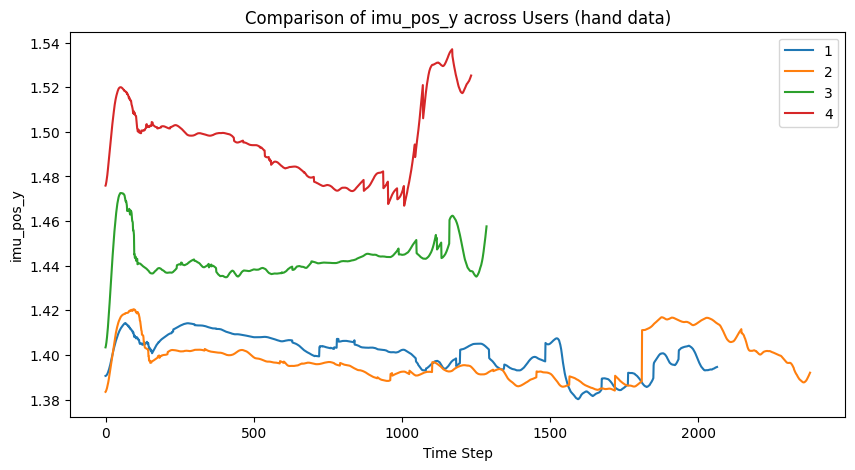

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Path to data folder
data_path = "data"

# Select input type (either "hand" or "controller")
selected_input = "hand"  # Change this to "controller" to switch

# List of allowed filenames to read
allowed_files = FILE_LIST  # Update this with exact filenames

# Dictionary to store data
all_data = []

# Iterate through users (folders 1-4)
for user in os.listdir(data_path):
    user_path = os.path.join(data_path, user)
    if not os.path.isdir(user_path):
        continue  # Skip if not a directory

    # Path to the selected input type (either "hand" or "controller")
    input_path = os.path.join(user_path, selected_input)
    if not os.path.isdir(input_path):
        continue  # Skip if this input type does not exist

    # Iterate through experiment repetitions (1-10)
    experiment_data = []
    for experiment in os.listdir(input_path):
        experiment_path = os.path.join(input_path, experiment)
        if not os.path.isdir(experiment_path):
            continue

        # Load only allowed CSV files in this experiment folder
        for file in os.listdir(experiment_path):
            if file in allowed_files:  # Only process allowed files
                file_path = os.path.join(experiment_path, file)
                df = pd.read_csv(file_path)
                
                # Add metadata
                df["User"] = user
                df["Experiment"] = experiment
                df["Step"] = df.index  # Use index as time progression

                experiment_data.append(df)

    # Compute mean over 10 repetitions
    if experiment_data:
        combined_df = pd.concat(experiment_data)
        mean_df = combined_df.groupby(["User", "Step"]).mean().reset_index()  # Average over repetitions
        all_data.append(mean_df)

# Combine all users
final_df = pd.concat(all_data)
final_df.columns = final_df.columns.str.strip()

# Feature to plot (replace with actual column name)
feature = "imu_pos_y"  # Change this to the column you want to analyze
feature_2 = "rh_pos_y"

# Extract computed features
final_df = extract_features(final_df)
# final_df = normalize_features(final_df, feature, [feature_2])

# Plot specific feature using Step as the x-axis
plt.figure(figsize=(10, 5))
sns.lineplot(data=final_df, x="Step", y=feature, hue="User", markers=True)
plt.title(f"Comparison of {feature} across Users ({selected_input} data)")
plt.xlabel("Time Step")
plt.ylabel(feature)
plt.legend()
plt.show()
